# Analysis of Monthly Stress Composites

This notebook will walk through the analysis of stress maps on a monthly timescale over the Shirase Glacier in Antarctica.

## Load in Packages

In [1]:
import geopandas as gpd
import numpy as np
import xarray as xr
import rioxarray as rxr

from shapely.geometry import Polygon
from shapely.geometry import Point
import matplotlib.pyplot as plt

import json
import blue_ice_tools as bit
import itslivetools

## Load in Shapefile, Velocity Data, and compute Stress

As shown at the end of the previous notebook, we have a function that can calculate stresses on all monthly timesteps in a given datacube. <br>
We will load in this data here, calculate the stresses, and compute them to memory later.

In [2]:
# Read in shapefile of Shirase Glacier
shirase_shape = gpd.read_file('../data/shirase-glacier/shirase.shp')

# Load in ITS_LIVE velocities with shape
shirase_dc = bit.get_data_cube(shape=shirase_shape, epsg=3031)

# Create a list of variable names
vars = ['eps_eff', 'eps_xx', 'eps_yy', 'sigma_vm', 'sigma1', 'sigma2']

# Call stress function, save outputs as new data vars
shirase_dc[vars] = bit.compute_strain_stress(shirase_dc.vx, shirase_dc.vy, rotate=True)
shirase_dc

<xarray.Dataset> Size: 750MB
Dimensions:      (mid_date: 97, y: 655, x: 328)
Coordinates:
  * x            (x) float64 3kB 1.344e+06 1.344e+06 ... 1.383e+06 1.384e+06
  * y            (y) float64 5kB 1.649e+06 1.65e+06 ... 1.728e+06 1.728e+06
    spatial_ref  int64 8B 0
    mapping      int64 8B 0
  * mid_date     (mid_date) datetime64[ns] 776B 2015-01-31 ... 2023-01-31
Data variables:
    v            (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    vx           (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    vy           (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    eps_eff      (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    eps_xx       (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    eps_yy       (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    sigma_vm     (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    sigma1       (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    sigma2       (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               26-Sep-2023 13:16:09
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/S70E030/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/S70E030/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

Now that a monthly timeseries of stress has been lazily computed with Dask, we can load the full dataset into memory.

The following block will issue a RuntimeWarning from the NaN values in the dataset. This error does not affect the computation of the data, it is simply a warning that trying to run the computations on NaN's will increase the runtime.

To avoid this warning, you can uncomment the line `%env PYTHONWARNINGS=ignore`.

In [3]:
# Optional line to silence runtime warnings that can be distracting
# %env PYTHONWARNINGS=ignore

# Compute data cube to memory
shirase_ds = shirase_dc.compute()
shirase_ds

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


<xarray.Dataset> Size: 750MB
Dimensions:      (mid_date: 97, y: 655, x: 328)
Coordinates:
  * x            (x) float64 3kB 1.344e+06 1.344e+06 ... 1.383e+06 1.384e+06
  * y            (y) float64 5kB 1.649e+06 1.65e+06 ... 1.728e+06 1.728e+06
    spatial_ref  int64 8B 0
    mapping      int64 8B 0
  * mid_date     (mid_date) datetime64[ns] 776B 2015-01-31 ... 2023-01-31
Data variables:
    v            (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan
    vx           (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan
    vy           (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan
    eps_eff      (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan
    eps_xx       (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan
    eps_yy       (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan
    sigma_vm     (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan
    sigma1       (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan
    sigma2       (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               26-Sep-2023 13:16:09
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/S70E030/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/S70E030/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

## Plot Temporal Average

Let's start by plotting the temporal average of Von Mises stress over Shirase Glacier to look for any interesting areas. I will also plot a velocity streamplot next to the stress maps to get an idea of flow speed and direction.

First that means we need to take a time average and save the mean velocity components. We will use the components to re-calculate the magnitude of velocity to avoid propegating error.

In [4]:
# Take temporal average of dataset
time_avg = shirase_ds.mean(dim='mid_date', skipna=True)

# Take x and y componenets of v, calculate magnitude
vx = time_avg.vx
vy = time_avg.vy
vv = np.sqrt((vx ** 2) + (vy ** 2))

Now that the temporal mean has been computed, we can plot the stress and velocity maps

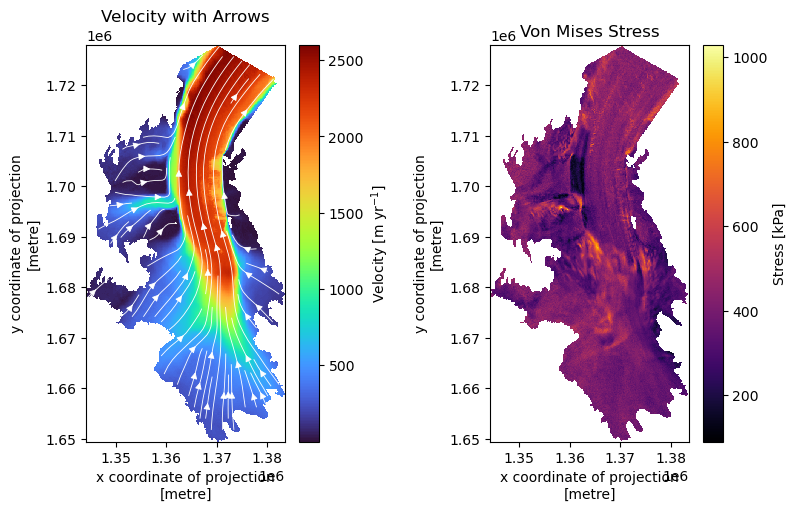

In [5]:
# create a figure with two subplots
fig, axs = plt.subplots(ncols=2, layout='constrained', figsize=(8,5))

# Plot velocity field w/ turbo colormap
vv.plot(ax=axs[0], cmap='turbo', cbar_kwargs={'label':'Velocity [m yr$^{-1}$]'})

# # Account for 'strictly increasing' requirement for streamplots in newer matplotlibs:
# # flip if Y is decreasing rather than increasing. This is only necessary for plotting
# streamplots, not quiverplots.
if vv.y.values[1] - vv.y.values[0] < 0:
    vv_flip = vv.reindex(y = vv.y[::-1])
    vx_flip = vx.reindex(y = vx.y[::-1])
    vy_flip = vy.reindex(y = vy.y[::-1])
else: 
    vv_flip = vv
    vx_flip = vx
    vy_flip = vy


# # Plot flow direction using streamplot
axs[0].streamplot(
    vv_flip.x.values, 
    vv_flip.y.values, 
    vx_flip.values, 
    vy_flip.values,
    color='white',
    linewidth=0.6,
    density=1.2,
)

# Plot Von Mises Stress
c = time_avg.sigma_vm.plot(ax=axs[1], cmap='inferno')
c.colorbar.set_label('Stress [kPa]')

titles = ['Velocity with Arrows', 'Von Mises Stress']
for ax, title in zip(axs, titles):
    ax.set_aspect('equal')
    ax.set_title(title)

plt.show()

There a two areas that may be interesting to look at as a timeseries:
- Near `(1.365e6, 1.69e6)`
- Near `(1.363e6, 1.705e6)`

Next, let's look at how the stress changes at and/or around those points over time

## Time Series at Specific Point

We'll save these x- and y-coordinates and use the `'nearest'` method to select the nearest location in the dataset to the value passed.

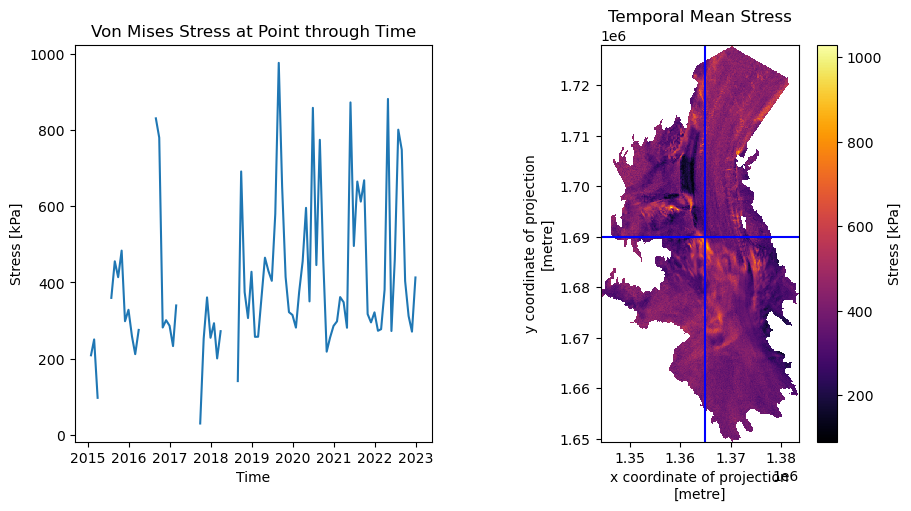

In [6]:
# Save x and y location as variables
x, y = (1.365e6, 1.69e6)

# select nearest point to specified location from main ds
point = shirase_ds.sel(x=x, y=y, method='nearest')

fig, axs = plt.subplots(ncols=2, layout='constrained', figsize=(9,5))

# plot timeseries of Von Mises Stress
point.sigma_vm.plot(ax=axs[0])
axs[0].set_title('Von Mises Stress at Point through Time')
axs[0].set_ylabel('Stress [kPa]')
axs[0].set_xlabel('Time')

# Plot Von Mises Stress
c = time_avg.sigma_vm.plot(ax=axs[1], cmap='inferno')
c.colorbar.set_label('Stress [kPa]')
axs[1].set_title('Temporal Mean Stress')
# Plot verticle and horizontal lines that intersect at point
axs[1].axhline(y=y, c='blue')
axs[1].axvline(x=x, c='blue')
axs[1].set_aspect('equal')

plt.show()

The yeild stress exerted on the ice here ranges from 200-800 kPa. This is very a large swing in derived values. There may even be some seasonality in the spikes. The higher values appear to line up with Antarctic winter (March-October).

Let's take a look at the next point, but instead of a single point, we are going to look at a spacial mean over a small region.

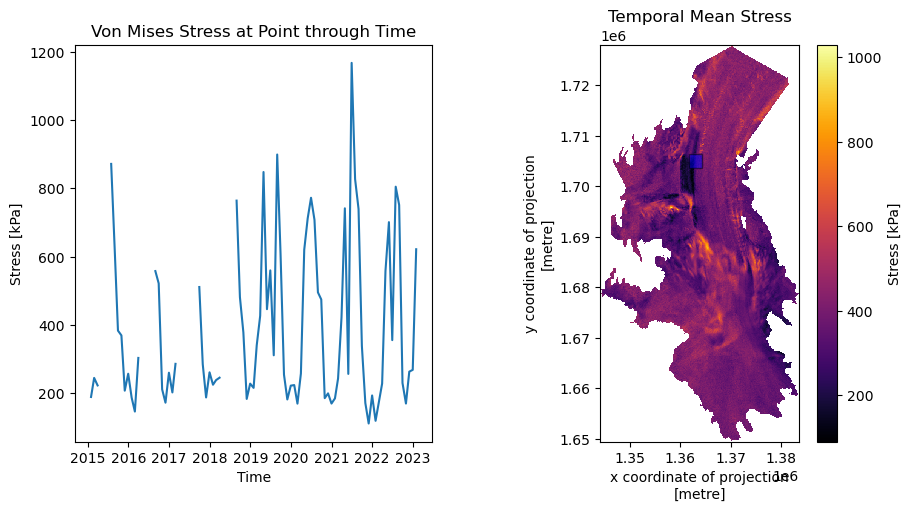

In [7]:
# Save x and y location as variables
x, y = (1.363e6, 1.705e6)

# buffer distance (amount to move each direction from coord)
buffer = 1.3e3
x1, x2 = x-buffer, x+buffer
y1, y2 = y-buffer, y+buffer

# select nearest point to specified location from main ds
point = shirase_ds.sel(x=[x1, x2], y=[y1, y2], method='nearest').mean(['x', 'y'])

fig, axs = plt.subplots(ncols=2, layout='constrained', figsize=(9,5))

# plot timeseries of Von Mises Stress
point.sigma_vm.plot(ax=axs[0])
axs[0].set_title('Von Mises Stress at Point through Time')
axs[0].set_ylabel('Stress [kPa]')
axs[0].set_xlabel('Time')

# Plot Von Mises Stress
c = time_avg.sigma_vm.plot(ax=axs[1], cmap='inferno')
c.colorbar.set_label('Stress [kPa]')
axs[1].set_title('Temporal Mean Stress')
# Plot verticle and horizontal lines that intersect at point
axs[1].fill([x1,x2,x2,x1], [y1,y1,y2,y2], facecolor='blue', edgecolor='k', alpha=.5)
axs[1].set_aspect('equal')

plt.show()

By using  the average over a region, we can increase the accuracy. Once again, we can see extremely high seasonal swings once again, ranging from 200 kPa during Summer, and over 800 kPa during Winter. Swings of this magnitude are strange.

Let's use the xarray groupby feature to look at a spatio-temporal average of the stress by season for any potential insights.

In [8]:
# Use the xarray groupby func to group by season
seasons_gb = shirase_ds.groupby(shirase_ds.mid_date.dt.season).mean(skipna=True)

# reindex the season so that the first to pixels are winter, second two are summer
seasons_gb = seasons_gb.reindex({'season':['MAM', 'JJA', 'SON', 'DJF']})

Now that we have grouped the dataset by season and taken a temporal mean, we can look at the maps for the indiviudal seasons.

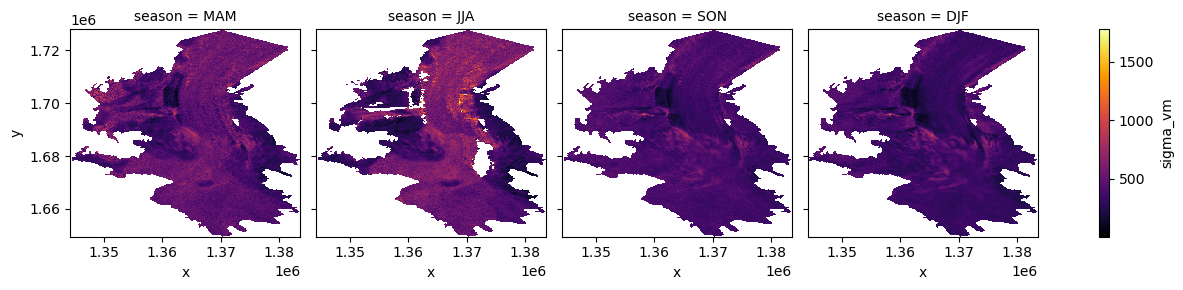

In [9]:
fg = seasons_gb.sigma_vm.plot(col='season', cmap='inferno')

The first two frames on the left are from Winter, and the two frames on the right are from Summer.

The highest stresses are during the hight of Antarctic winter. The data in the Winter appears to be much noisier than the summer data, and has many mising areas, especially during the June, July, and August frame. 

This may be an artifact of the combination of Sentinel-1 Backscatter and Landsat-8 feature tracking that causes an increase in noise and decrease in data coverage during the darkest months of antarctic winter. 

Lets plot a histogram of the spatial average of these monthly stresses to see quantatively if our visual inspection is correct.

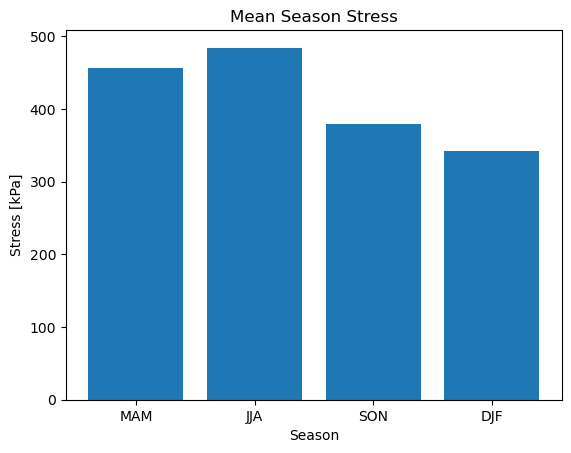

In [10]:
seasonal_stress = seasons_gb.sigma_vm.mean(dim=['x', 'y'])

fig, ax = plt.subplots()

ax.bar(height=seasonal_stress.data, x=seasonal_stress.season.data)
ax.set_ylabel('Stress [kPa]')
ax.set_xlabel('Season')
ax.set_title('Mean Season Stress')

plt.show()

This histogram backs up our visual guess from the maps.

## Conclusion

We have now seen some analysis of the stresses on a timescale, including monthly and seasonal.

In the next notebook, we will look at the time vary stresses in comparison with time varying fracture maps.